In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    %load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from Model.preprocessing.pipelines import ProcessData, Data_Process
from Model.preprocessing.datasetManager import DatasetManger
from Model.base.evaluator import EvalutionClassifer, Drow, Drow_mean, Save_fig
from Model.base.augmentation import Augmentation, Strategies
from ydata_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, RocCurveDisplay, classification_report
from sklearn.pipeline import Pipeline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_pd = pd.read_csv("../dataset/FullDatasetAndWavlet.csv", index_col="annot_id")
dataset_pd.loc["125_"] = dataset_pd.loc["125_"].fillna(0.9)
X = dataset_pd.drop(["histopath_diagnosis"], axis=1)

Y = dataset_pd["histopath_diagnosis"]
test_size = 0.20

managerdataset = DatasetManger(X, Y, batch_size=2, n_splits=2, test_size=test_size)

features_train, label_train, features_test, label_test = managerdataset.split()[0]

In [3]:
augmentor_training = Augmentation(features_train, label_train)
features_train, label_train = augmentor_training.generate( Strategies.OverSampling)
augmentor_test = Augmentation(features_test, label_test)
features_test, label_test = augmentor_test.generate(Strategies.OverSampling)

In [4]:
categorical_features = ["sex", "location"]

Ti_rads_featurea = ["ti-rads_composition", "ti-rads_echogenicity",
                    "ti-rads_margin", "ti-rads_shape", "ti-rads_echogenicfoci"]

numerical_features = list(X[X.columns[~X.columns.isin(
    categorical_features + Ti_rads_featurea)]].columns)

scaler = Data_Process(features_train, categorical_features, numerical_features, Ti_rads_featurea)
features_train = scaler.fit_transform()
features_test = scaler.transform(features_test)

In [6]:
print("number of data in training dataset: " + str(len(features_train)))
print("number of data in test dataset: " + str(len(features_test)))
print("Shape of data: " + str(dataset_pd.shape))

number of data in training dataset: 24710
number of data in test dataset: 6178
Shape of data: (17412, 487)


In [6]:
features_train_np = features_train.to_numpy()
label_train_np = label_train.to_numpy()
features_test_np = features_test.to_numpy()
label_test_np = label_test.to_numpy()

In [7]:
pipeline = Pipeline([
        #('pcr', PCA()),
        ('lasso', Lasso())
])

In [8]:
classifer = Lasso()
config = {
    'lasso__alpha': [0.0003],  # np.arange(0.0001, 0.001, 0.0001),
    #'pcr__n_components': np.arange(2, 100, 1),
    'lasso__max_iter': [245000]
}
grid_search = GridSearchCV(pipeline, config, cv=8, scoring="neg_mean_squared_error", verbose=3, n_jobs=-1)

In [9]:
grid_search.fit(features_train_np, label_train_np)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


GridSearchCV(cv=8, estimator=Pipeline(steps=[('lasso', Lasso())]), n_jobs=-1,
             param_grid={'lasso__alpha': [0.0003], 'lasso__max_iter': [245000]},
             scoring='neg_mean_squared_error', verbose=3)

In [10]:
print("This is the best model: " + str(grid_search.best_params_))

This is the best model: {'lasso__alpha': 0.0003, 'lasso__max_iter': 245000}


In [11]:
print(grid_search.best_estimator_[0].coef_)

[ 4.09487031e-02 -7.07979682e-14  7.40960544e-02  0.00000000e+00
 -8.87724579e-02 -6.10335528e-02 -4.25787777e-02 -0.00000000e+00
 -0.00000000e+00  1.83830063e-01 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -2.19734625e-02  0.00000000e+00 -0.00000000e+00
  1.54737497e-02 -0.00000000e+00  6.90935771e-02  3.93567164e-02
  4.80848255e-02 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  4.96559679e-03  2.28318883e-03  0.00000000e+00 -1.66695593e-02
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -8.71489773e-03  2.19258938e-18  4.79556444e-02
 -0.00000000e+00 -0.00000

In [12]:
selected_features_by_lasso = features_train.loc[:, grid_search.best_estimator_[0].coef_ != 0]

In [13]:
print("count of selected features: " + str(len(list(selected_features_by_lasso.columns))))

count of selected features: 202


In [14]:
print("list of selected features")
list(selected_features_by_lasso.columns)

list of selected features


['categorical__sex_Female',
 'categorical__sex_Male',
 'categorical__location_isthmus',
 'categorical__location_right',
 'num__original_shape2D_Elongation',
 'num__original_shape2D_MajorAxisLength',
 'num__original_shape2D_MinorAxisLength',
 'num__original_shape2D_Sphericity',
 'num__original_firstorder_Energy',
 'num__original_firstorder_InterquartileRange',
 'num__original_firstorder_Kurtosis',
 'num__original_firstorder_Maximum',
 'num__original_firstorder_Skewness',
 'num__original_firstorder_TotalEnergy',
 'num__original_firstorder_Variance',
 'num__original_glrlm_GrayLevelNonUniformityNormalized',
 'num__original_glrlm_GrayLevelVariance',
 'num__original_glrlm_HighGrayLevelRunEmphasis',
 'num__original_glrlm_LowGrayLevelRunEmphasis',
 'num__original_glrlm_RunLengthNonUniformity',
 'num__original_glrlm_ShortRunEmphasis',
 'num__original_glrlm_ShortRunHighGrayLevelEmphasis',
 'num__original_glszm_HighGrayLevelZoneEmphasis',
 'num__original_glszm_LargeAreaHighGrayLevelEmphasis',
 'n

In [15]:
label_predict_by_lasso = grid_search.best_estimator_.predict(features_test_np)
label_predict_by_lasso = label_predict_by_lasso > 0.5
print(classification_report(label_test_np, label_predict_by_lasso))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      3089
           1       0.90      0.97      0.94      3089

    accuracy                           0.93      6178
   macro avg       0.94      0.93      0.93      6178
weighted avg       0.94      0.93      0.93      6178



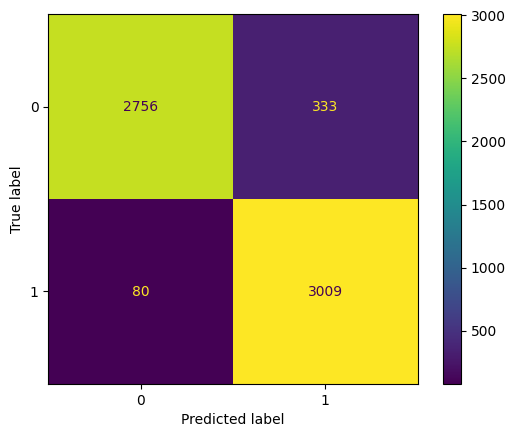

In [16]:
conf_mat = confusion_matrix(label_test_np, label_predict_by_lasso)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

In [17]:
selected_features_by_lasso.tail()

,categorical__sex_Female,categorical__sex_Male,categorical__location_isthmus,categorical__location_right,num__original_shape2D_Elongation,num__original_shape2D_MajorAxisLength,num__original_shape2D_MinorAxisLength,num__original_shape2D_Sphericity,num__original_firstorder_Energy,num__original_firstorder_InterquartileRange,num__original_firstorder_Kurtosis,num__original_firstorder_Maximum,num__original_firstorder_Skewness,num__original_firstorder_TotalEnergy,num__original_firstorder_Variance,num__original_glrlm_GrayLevelNonUniformityNormalized,num__original_glrlm_GrayLevelVariance,num__original_glrlm_HighGrayLevelRunEmphasis,num__original_glrlm_LowGrayLevelRunEmphasis,num__original_glrlm_RunLengthNonUniformity,num__original_glrlm_ShortRunEmphasis,num__original_glrlm_ShortRunHighGrayLevelEmphasis,num__original_glszm_HighGrayLevelZoneEmphasis,num__original_glszm_LargeAreaHighGrayLevelEmphasis,num__original_glszm_LargeAreaLowGrayLevelEmphasis,num__original_glszm_LowGrayLevelZoneEmphasis,num__original_glszm_SizeZoneNonUniformity,num__original_glszm_SizeZoneNonUniformityNormalized,num__original_glszm_SmallAreaEmphasis,num__original_glszm_SmallAreaHighGrayLevelEmphasis,num__original_glszm_ZoneEntropy,num__original_glszm_ZonePercentage,num__original_gldm_DependenceNonUniformityNormalized,num__original_gldm_LargeDependenceEmphasis,num__original_gldm_SmallDependenceEmphasis,num__original_gldm_SmallDependenceLowGrayLevelEmphasis,num__original_ngtdm_Busyness,num__original_ngtdm_Coarseness,num__original_ngtdm_Strength,num__wavelet-LH_firstorder_10Percentile,num__wavelet-LH_firstorder_Energy,num__wavelet-LH_firstorder_Entropy,num__wavelet-LH_firstorder_Kurtosis,num__wavelet-LH_firstorder_Maximum,num__wavelet-LH_firstorder_Mean,num__wavelet-LH_firstorder_Median,num__wavelet-LH_firstorder_Range,num__wavelet-LH_firstorder_Skewness,num__wavelet-LH_firstorder_TotalEnergy,num__wavelet-LH_glcm_Imc1,num__wavelet-LH_glcm_JointAverage,num__wavelet-LH_glcm_MaximumProbability,num__wavelet-LH_glcm_SumAverage,num__wavelet-LH_glcm_SumEntropy,num__wavelet-LH_glrlm_GrayLevelNonUniformityNormalized,num__wavelet-LH_glrlm_GrayLevelVariance,num__wavelet-LH_glrlm_HighGrayLevelRunEmphasis,num__wavelet-LH_glrlm_RunEntropy,num__wavelet-LH_glrlm_RunLengthNonUniformity,num__wavelet-LH_glrlm_RunVariance,num__wavelet-LH_glszm_GrayLevelNonUniformityNormalized,num__wavelet-LH_glszm_GrayLevelVariance,num__wavelet-LH_glszm_HighGrayLevelZoneEmphasis,num__wavelet-LH_glszm_LargeAreaHighGrayLevelEmphasis,num__wavelet-LH_glszm_LowGrayLevelZoneEmphasis,num__wavelet-LH_glszm_SizeZoneNonUniformity,num__wavelet-LH_glszm_SizeZoneNonUniformityNormalized,num__wavelet-LH_glszm_SmallAreaEmphasis,num__wavelet-LH_glszm_SmallAreaLowGrayLevelEmphasis,num__wavelet-LH_glszm_ZoneEntropy,num__wavelet-LH_glszm_ZonePercentage,num__wavelet-LH_glszm_ZoneVariance,num__wavelet-LH_gldm_DependenceEntropy,num__wavelet-LH_gldm_DependenceNonUniformity,num__wavelet-LH_gldm_DependenceVariance,num__wavelet-LH_gldm_HighGrayLevelEmphasis,num__wavelet-LH_gldm_LowGrayLevelEmphasis,num__wavelet-LH_ngtdm_Busyness,num__wavelet-LH_ngtdm_Coarseness,num__wavelet-HL_firstorder_Energy,num__wavelet-HL_firstorder_InterquartileRange,num__wavelet-HL_firstorder_Kurtosis,num__wavelet-HL_firstorder_Maximum,num__wavelet-HL_firstorder_Mean,num__wavelet-HL_firstorder_Median,num__wavelet-HL_firstorder_Minimum,num__wavelet-HL_firstorder_RootMeanSquared,num__wavelet-HL_firstorder_TotalEnergy,num__wavelet-HL_firstorder_Variance,num__wavelet-HL_glcm_MaximumProbability,num__wavelet-HL_glcm_SumEntropy,num__wavelet-HL_glcm_SumSquares,num__wavelet-HL_glrlm_GrayLevelNonUniformityNormalized,num__wavelet-HL_glrlm_HighGrayLevelRunEmphasis,num__wavelet-HL_glrlm_LongRunHighGrayLevelEmphasis,num__wavelet-HL_glrlm_LowGrayLevelRunEmphasis,num__wavelet-HL_glrlm_RunLengthNonUniformity,num__wavelet-HL_glrlm_RunLengthNonUniformityNormalized,num__wavelet-HL_glrlm_ShortRunHighGrayLevelEmphasis,num__wavelet-HL_glrlm_ShortRunLowGrayLevelEmphasis,num__wavel

In [18]:
selected_features_by_lasso["categorical__location_left"] = features_train["categorical__location_left"]

C:\Users\User\AppData\Local\Temp\ipykernel_23576\196270165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_by_lasso["categorical__location_left"] = features_train["categorical__location_left"]


In [19]:
selected_features_by_lasso.head()

,categorical__sex_Female,categorical__sex_Male,categorical__location_isthmus,categorical__location_right,num__original_shape2D_Elongation,num__original_shape2D_MajorAxisLength,num__original_shape2D_MinorAxisLength,num__original_shape2D_Sphericity,num__original_firstorder_Energy,num__original_firstorder_InterquartileRange,num__original_firstorder_Kurtosis,num__original_firstorder_Maximum,num__original_firstorder_Skewness,num__original_firstorder_TotalEnergy,num__original_firstorder_Variance,num__original_glrlm_GrayLevelNonUniformityNormalized,num__original_glrlm_GrayLevelVariance,num__original_glrlm_HighGrayLevelRunEmphasis,num__original_glrlm_LowGrayLevelRunEmphasis,num__original_glrlm_RunLengthNonUniformity,num__original_glrlm_ShortRunEmphasis,num__original_glrlm_ShortRunHighGrayLevelEmphasis,num__original_glszm_HighGrayLevelZoneEmphasis,num__original_glszm_LargeAreaHighGrayLevelEmphasis,num__original_glszm_LargeAreaLowGrayLevelEmphasis,num__original_glszm_LowGrayLevelZoneEmphasis,num__original_glszm_SizeZoneNonUniformity,num__original_glszm_SizeZoneNonUniformityNormalized,num__original_glszm_SmallAreaEmphasis,num__original_glszm_SmallAreaHighGrayLevelEmphasis,num__original_glszm_ZoneEntropy,num__original_glszm_ZonePercentage,num__original_gldm_DependenceNonUniformityNormalized,num__original_gldm_LargeDependenceEmphasis,num__original_gldm_SmallDependenceEmphasis,num__original_gldm_SmallDependenceLowGrayLevelEmphasis,num__original_ngtdm_Busyness,num__original_ngtdm_Coarseness,num__original_ngtdm_Strength,num__wavelet-LH_firstorder_10Percentile,num__wavelet-LH_firstorder_Energy,num__wavelet-LH_firstorder_Entropy,num__wavelet-LH_firstorder_Kurtosis,num__wavelet-LH_firstorder_Maximum,num__wavelet-LH_firstorder_Mean,num__wavelet-LH_firstorder_Median,num__wavelet-LH_firstorder_Range,num__wavelet-LH_firstorder_Skewness,num__wavelet-LH_firstorder_TotalEnergy,num__wavelet-LH_glcm_Imc1,num__wavelet-LH_glcm_JointAverage,num__wavelet-LH_glcm_MaximumProbability,num__wavelet-LH_glcm_SumAverage,num__wavelet-LH_glcm_SumEntropy,num__wavelet-LH_glrlm_GrayLevelNonUniformityNormalized,num__wavelet-LH_glrlm_GrayLevelVariance,num__wavelet-LH_glrlm_HighGrayLevelRunEmphasis,num__wavelet-LH_glrlm_RunEntropy,num__wavelet-LH_glrlm_RunLengthNonUniformity,num__wavelet-LH_glrlm_RunVariance,num__wavelet-LH_glszm_GrayLevelNonUniformityNormalized,num__wavelet-LH_glszm_GrayLevelVariance,num__wavelet-LH_glszm_HighGrayLevelZoneEmphasis,num__wavelet-LH_glszm_LargeAreaHighGrayLevelEmphasis,num__wavelet-LH_glszm_LowGrayLevelZoneEmphasis,num__wavelet-LH_glszm_SizeZoneNonUniformity,num__wavelet-LH_glszm_SizeZoneNonUniformityNormalized,num__wavelet-LH_glszm_SmallAreaEmphasis,num__wavelet-LH_glszm_SmallAreaLowGrayLevelEmphasis,num__wavelet-LH_glszm_ZoneEntropy,num__wavelet-LH_glszm_ZonePercentage,num__wavelet-LH_glszm_ZoneVariance,num__wavelet-LH_gldm_DependenceEntropy,num__wavelet-LH_gldm_DependenceNonUniformity,num__wavelet-LH_gldm_DependenceVariance,num__wavelet-LH_gldm_HighGrayLevelEmphasis,num__wavelet-LH_gldm_LowGrayLevelEmphasis,num__wavelet-LH_ngtdm_Busyness,num__wavelet-LH_ngtdm_Coarseness,num__wavelet-HL_firstorder_Energy,num__wavelet-HL_firstorder_InterquartileRange,num__wavelet-HL_firstorder_Kurtosis,num__wavelet-HL_firstorder_Maximum,num__wavelet-HL_firstorder_Mean,num__wavelet-HL_firstorder_Median,num__wavelet-HL_firstorder_Minimum,num__wavelet-HL_firstorder_RootMeanSquared,num__wavelet-HL_firstorder_TotalEnergy,num__wavelet-HL_firstorder_Variance,num__wavelet-HL_glcm_MaximumProbability,num__wavelet-HL_glcm_SumEntropy,num__wavelet-HL_glcm_SumSquares,num__wavelet-HL_glrlm_GrayLevelNonUniformityNormalized,num__wavelet-HL_glrlm_HighGrayLevelRunEmphasis,num__wavelet-HL_glrlm_LongRunHighGrayLevelEmphasis,num__wavelet-HL_glrlm_LowGrayLevelRunEmphasis,num__wavelet-HL_glrlm_RunLengthNonUniformity,num__wavelet-HL_glrlm_RunLengthNonUniformityNormalized,num__wavelet-HL_glrlm_ShortRunHighGrayLevelEmphasis,num__wavelet-HL_glrlm_ShortRunLowGrayLevelEmphasis,num__wavel

In [20]:
label_train

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        1
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       1
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
35       0
36       0
37       0
38       0
39       0
40       0
41       0
42       0
43       0
44       0
45       0
46       0
47       0
48       0
49       0
50       0
51       0
52       0
53       0
54       0
55       0
56       1
57       0
58       0
59       1
60       0
61       1
62       0
63       0
64       0
65       1
66       0
67       0
68       0
69       0
70       1
71       0
72       1
73       0
74       0
75       1
76       1
77       1
78       0
79       0
80       0
81       0
82       0
83       0
84       0
85       0
86       0
87       0
88       0
89       0
90       0

In [21]:
selected_features_by_lasso.insert(0, "Target", label_train)

import pymrmr
selected_features_columns_by_mrmr = pymrmr.mRMR(selected_features_by_lasso, "MIQ", 30)

In [22]:
selected_features_columns_by_mrmr

['num__ti-rads_level',
 'num__original_ngtdm_Coarseness',
 'num__wavelet-HH_glcm_MaximumProbability',
 'num__wavelet-LH_glszm_LargeAreaHighGrayLevelEmphasis',
 'categorical__sex_Female',
 'num__age',
 'num__size_x',
 'tirads__ti-rads_margin',
 'tirads__ti-rads_echogenicfoci',
 'num__wavelet-LH_glcm_SumEntropy',
 'num__original_firstorder_Kurtosis',
 'num__wavelet-LL_glszm_LargeAreaLowGrayLevelEmphasis',
 'num__wavelet-HL_firstorder_Energy',
 'num__size_y',
 'tirads__ti-rads_shape',
 'num__wavelet-HH_glrlm_RunLengthNonUniformityNormalized',
 'num__size_z',
 'num__wavelet-LL_glcm_MCC',
 'num__wavelet-HH_firstorder_Variance',
 'num__wavelet-HL_glszm_HighGrayLevelZoneEmphasis',
 'num__wavelet-HH_glszm_LargeAreaHighGrayLevelEmphasis',
 'num__original_firstorder_InterquartileRange',
 'num__wavelet-HL_glrlm_ShortRunLowGrayLevelEmphasis',
 'num__wavelet-HL_glszm_LargeAreaHighGrayLevelEmphasis',
 'num__original_firstorder_Skewness',
 'num__wavelet-LH_gldm_DependenceEntropy',
 'num__original_gls

In [23]:
features_slected_by_mrmr = features_train[selected_features_columns_by_mrmr]

In [24]:
features_slected_by_mrmr["Target"] = label_train

C:\Users\User\AppData\Local\Temp\ipykernel_23576\3636628321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_slected_by_mrmr["Target"] = label_train


In [25]:
features_slected_by_mrmr.to_csv("./../dataset/column_selected_by_lasso_mrmr.csv")

In [24]:
features_slected_by_mrmr.head()

,num__ti-rads_level,num__wavelet-LL_ngtdm_Coarseness,num__original_shape2D_Sphericity,num__wavelet-LH_glszm_LargeAreaHighGrayLevelEmphasis,num__wavelet-HH_glcm_MaximumProbability,tirads__ti-rads_margin,num__wavelet-LH_glcm_SumEntropy,tirads__ti-rads_echogenicfoci,num__size_x,num__age,num__original_firstorder_Kurtosis,num__size_z,num__wavelet-HL_firstorder_Skewness,num__wavelet-HL_firstorder_Energy,num__size_y,tirads__ti-rads_shape,num__wavelet-LL_glszm_LargeAreaLowGrayLevelEmphasis,num__wavelet-HH_glrlm_RunLengthNonUniformityNormalized,num__wavelet-HH_firstorder_Variance,num__wavelet-HH_glszm_LargeAreaHighGrayLevelEmphasis,num__wavelet-HL_glszm_HighGrayLevelZoneEmphasis,num__original_firstorder_InterquartileRange,num__wavelet-LL_glcm_MCC,num__original_firstorder_Skewness,num__wavelet-HL_glszm_LargeAreaHighGrayLevelEmphasis,num__wavelet-HL_glrlm_ShortRunLowGrayLevelEmphasis,num__wavelet-LH_glszm_SizeZoneNonUniformity,num__wavelet-LH_glrlm_LongRunHighGrayLevelEmphasis,num__wavelet-HL_firstorder_TotalEnergy,num__wavelet-HH_glcm_Imc2
0,-0.253225,-0.190006,0.660352,0.666585,0.020191,-1.0,1.384358,0.5,0.046204,-1.289803,0.102731,-0.128381,0.842033,-0.507664,0.572558,-1.0,-0.013357,0.878044,-1.284334,0.287022,0.988091,-0.660353,1.030722,1.033464,0.252466,1.054013,0.360659,-0.366196,-0.507664,0.390459
1,-1.467270,-0.190006,-0.993252,2.335095,-0.325212,-1.0,1.013802,-1.0,0.605672,-0.611679,-0.515649,1.703700,-0.127367,0.427445,0.356022,-1.0,1.232770,-0.778546,-1.010306,1.124503,-0.039334,-0.710408,-1.491731,-0.931885,1.313898,-0.717394,0.918262,-0.075170,0.427445,-0.281478
2,-0.253225,-0.190006,0.337545,1.145749,0.687713,-1.0,1.429510,-0.5,3.216525,-0.136992,-0.045360,-0.031956,0.103720,-0.102926,2.304845,-1.0,0.829206,0.835583,-1.151006,1.261456,0.043360,-0.937202,-0.659689,-0.129397,0.816787,-0.847625,2.265865,-1.434938,-0.102926,1.903118
3,-0.253225,-0.190006,0.153744,0.305066,-0.527174,-1.0,1.431958,0.0,2.097588,2.643319,-0.422506,2.475103,0.008223,0.179939,6.202490,-1.0,0.066574,-1.978426,-0.552612,-0.177937,0.330344,0.297915,0.892915,-1.208115,0.228972,-2.715515,0.385042,-1.595085,0.179939,-0.787699
4,-1.467270,-0.190006,-2.164914,-0.646505,-0.093322,-1.0,-0.273379,-1.0,-0.233531,0.405508,-0.450823,-0.899784,0.725207,-0.710426,-0.834925,-1.0,-0.139964,1.691122,-0.718979,-0.708528,0.016586,-0.432605,0.228934,-1.033739,-0.582918,1.631196,-0.720198,1.464223,-0.710426,0.155469


In [ ]:
Target